# Introduction to Agentic AI

Welcome to this hands-on workshop on Agentic AI systems. In this session, you'll learn how to build an intelligent AI fashion assistant that demonstrates key concepts of agentic behavior.

## What You'll Build

An AI agent that can:
- Check real-time weather data using external APIs
- Browse through clothing options from a wardrobe database
- Make intelligent decisions by combining multiple data sources
- Maintain conversation context across multiple interactions

![image.png](attachment:9c976bfa-ff23-4582-b4c7-eca7bbdb7c57.png)

## Learning Objectives

This workshop focuses on building **agents** rather than simple chatbots. By the end, you'll understand how to create AI systems that can:

1. **Use tools** to gather real-time information from external sources
2. **Make decisions** based on combined data inputs
3. **Remember context** across multiple conversation turns
4. **Reason through multi-step processes** to complete complex tasks

## Key Concepts Covered

- Tool integration and function calling
- State management in conversational AI
- The ReAct (Reasoning + Acting) pattern
- Persistent memory systems
- Graph-based agent architectures

Let's begin by installing the required dependencies:

In [14]:
! pip install -r ./requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Part 1: Setting Up the Language Model

Now we'll configure the core language model that will serve as the reasoning engine for our agent.

## The Role of the Language Model

The language model functions as the central intelligence of our agent system. It handles:
- **Input interpretation**: Understanding user requests and context
- **Decision making**: Determining when and which tools to use
- **Response generation**: Creating natural, helpful responses based on tool outputs

## Why Azure OpenAI GPT-4

We're using Azure OpenAI's GPT-4 model because it excels at:
- Understanding complex, multi-step instructions
- Making intelligent decisions about tool usage
- Maintaining context across conversation turns
- Generating coherent responses that integrate information from multiple sources

## Implementation

The language model serves as the orchestrator that coordinates between user input, tool execution, and response generation. Without this component, we would only have disconnected functions rather than an integrated intelligent system.

Let's initialize the language model:

In [16]:
from langchain_openai import AzureChatOpenAI
import os

# Set your Azure credentials
os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://evo-bots.openai.azure.com/'
os.environ['AZURE_OPENAI_API_KEY'] = 'SECRET'
os.environ['OPENAI_API_VERSION'] = '2024-12-01-preview'
# Create the LLM
llm = AzureChatOpenAI(
    azure_deployment='gpt-4.1-mini',
    model='gpt-4.1-mini',
    temperature=0.0,
)

messages = [("user", "What's agentic AI?")]
response = llm.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

Agentic AI refers to artificial intelligence systems that exhibit characteristics of an "agent," meaning they can perceive their environment, make decisions, and take actions autonomously to achieve specific goals. Unlike passive AI systems that only respond to inputs or perform predefined tasks, agentic AI has a degree of independence and proactive behavior, often involving planning, learning, and adapting over time.

Key features of agentic AI include:

- **Autonomy:** The ability to operate without constant human intervention.
- **Goal-directed behavior:** Acting with the purpose of achieving certain objectives.
- **Perception and reasoning:** Sensing the environment and making decisions based on that information.
- **Adaptability:** Learning from experience to improve performance or adjust strategies.

Agentic AI is commonly discussed in contexts such as robotics, autonomous vehicles, virtual assistan

# Part 2: Creating Tools for Agent Functionality

## Understanding Tools in Agentic AI

Tools are the primary mechanism that allows language models to interact with external systems and data sources. They extend the capabilities of static language models by enabling dynamic information retrieval and action execution.

### Function vs. Tool-Enabled Agents

**Static Language Models:**
- Limited to training data knowledge cutoffs
- Cannot access real-time information
- Purely generative with no external interaction capabilities

**Tool-Enabled Agents:**
- Can execute functions to gather current data
- Interact with APIs, databases, and external services
- Make decisions based on fresh, context-specific information
- Perform actions in real-world systems

## Tool Architecture

Tools in this system are Python functions with specific annotations that:
1. Define clear input parameters and types
2. Include comprehensive docstrings for the LLM to understand their purpose
3. Return structured data that the LLM can process
4. Handle errors gracefully to maintain agent stability

## Our Implementation

We'll implement two core tools for our fashion assistant:

1. **Weather API Tool**: Retrieves current weather conditions for location-based recommendations
2. **Wardrobe Database Tool**: Queries clothing inventory based on event types and requirements

These tools demonstrate the fundamental patterns you'll use when building any agentic system.
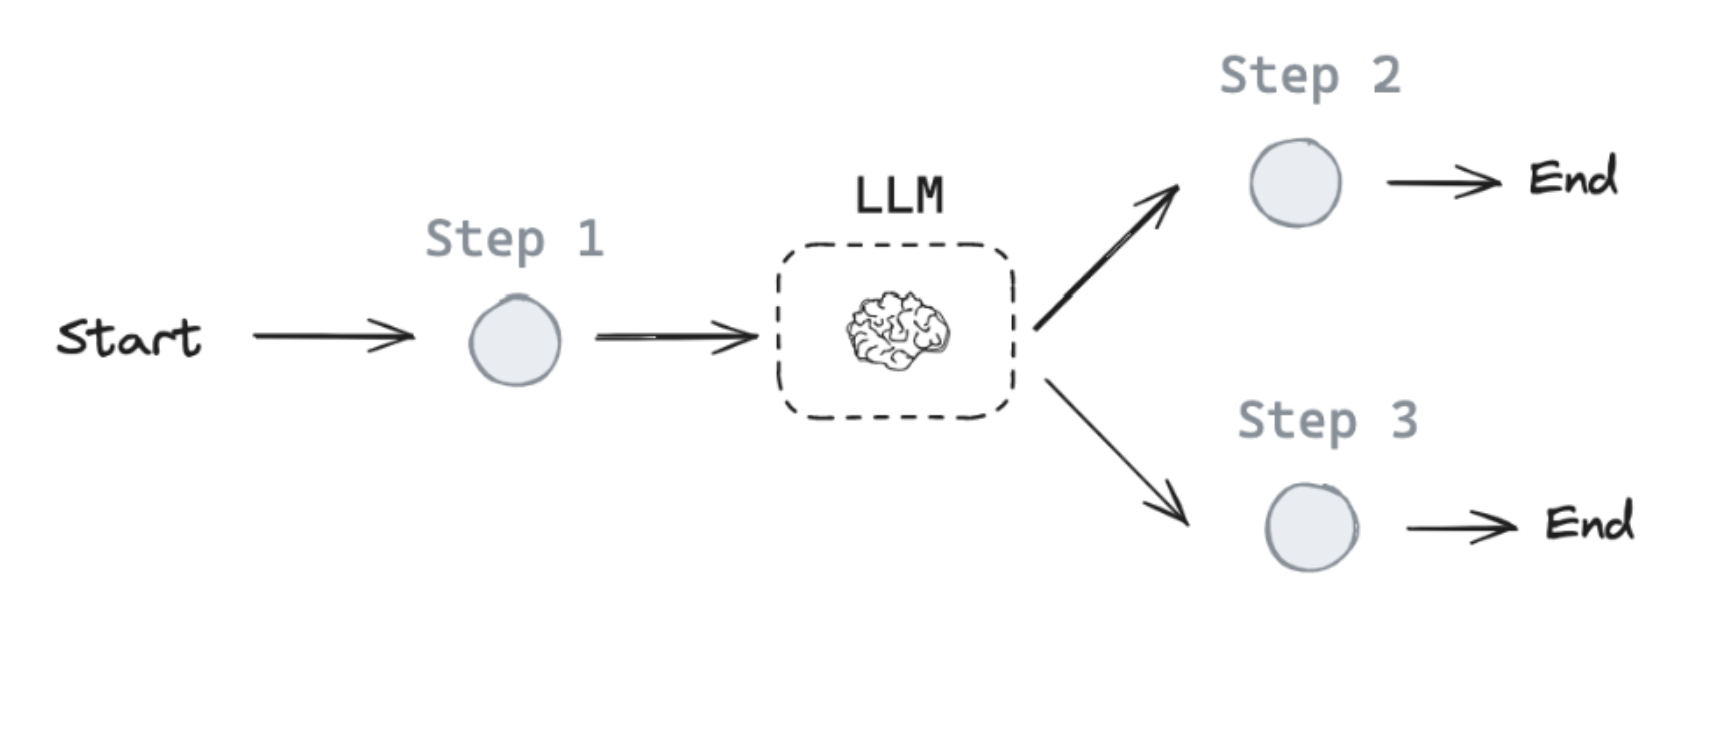

### Weather Tool Implementation

The `get_weather` function integrates with the Visual Crossing Weather API to retrieve real-time weather data for any specified location. This tool enables the agent to make contextually appropriate outfit recommendations based on current conditions.

**Key Implementation Details:**
- Uses HTTP requests to query external weather API
- Extracts relevant data points (temperature, conditions, precipitation probability)
- Implements error handling for API failures
- Returns structured data that the LLM can easily interpret

When this function is bound to the language model, the AI automatically recognizes when weather information is needed to fulfill a user request.

In [17]:
import requests


def get_weather(location: str) -> dict:
    """Get current weather for a specified location.

    Args:
        location: Name of the city or location

    Returns:
        Dictionary containing current temperature, conditions, and chance of rain
    """
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/today?unitGroup=metric&include=current&key=QJDGCRHSQ2U7QFVP59UFA5YMJ&contentType=json"

    try:
        response = requests.get(url)
        data = response.json()

        # Extract only the required information
        weather_info = {
            "temperature": data["currentConditions"]["temp"],
            "conditions": data["currentConditions"]["conditions"],
            "chance_of_rain": data["currentConditions"]["precipprob"]
        }

        return weather_info
    except Exception as e:
        return {"error": str(e)}

Let's test our weather tool to verify it functions correctly before integration.

Testing tools independently is a critical step in agent development - it ensures each component works as expected before adding the complexity of LLM orchestration.

In [18]:
# Direct function test
weather_data = get_weather("Cluj-Napoca")
print(f"Current weather in Cluj-Napoca:")
print(f"Temperature: {weather_data['temperature']}°C")
print(f"Conditions: {weather_data['conditions']}")
print(f"Chance of rain: {weather_data['chance_of_rain']}%")

Current weather in Cluj-Napoca:
Temperature: 15.8°C
Conditions: Partially cloudy
Chance of rain: 0.0%


### Wardrobe Tool Implementation

The `get_wardrobe_for_event` function simulates a clothing database lookup. In production systems, this would typically connect to a user's actual wardrobe inventory, e-commerce catalog, or fashion recommendation database.

**Data Structure:**
- Each clothing item maps to applicable event types (wedding, business, party, casual, gym)
- Items include descriptive details about weight, formality, and style
- The function filters items based on event type requirements

**Functionality:**
- Takes an event type as input parameter
- Returns all clothing items suitable for that event
- Provides structured data for the LLM to incorporate into recommendations

This tool demonstrates how agents can work with structured data and business logic to provide contextually appropriate suggestions.

In [25]:
WARDROBE = {
    "Navy Blue Blazer (light, formal cut)": ["wedding", "business"],
    "White Dress Shirt (light, breathable cotton)": ["wedding", "business"],
    "Charcoal Suit Pants (lightweight formal fabric)": ["wedding", "business"],
    "Formal Black Shoes (polished leather)": ["wedding", "business"],
    "Elegant Red Dress (light, satin)": ["wedding", "party"],
    "Black Tie (silk, formal)": ["wedding", "business"],
    "Beige Linen Suit (light, summer style)": ["wedding"],
    "Black Wool Suit (thick, winter)": ["wedding"],
    "Silver Cufflinks (formal accessory)": ["wedding"],
    "Leather Dress Belt (polished black leather)": ["wedding", "business"],
    "Grey Business Suit (medium weight, tailored)": ["business"],
    "Light Blue Oxford Shirt (light cotton)": ["business"],
    "Black Loafers (semi-formal leather shoes)": ["business"],
    "Navy Tie (silk, conservative style)": ["business"],
    "Charcoal Vest (medium weight, formal)": ["business"],
    "Brown Leather Briefcase (accessory)": ["business"],
    "White Cotton Undershirt (light base layer)": ["business"],
    "Black Dress Socks (thin, formal)": ["business"],
    "Black Leather Jacket (thick, edgy style)": ["casual", "party"],
    "Graphic T-Shirt (light, printed design)": ["casual", "party"],
    "Slim-Fit Jeans (dark blue, versatile)": ["casual", "party"],
    "Wool Sweater (thick, warm)": ["casual", "business"],
    "Cargo Pants (medium weight, outdoor style)": ["casual"],
    "Denim Jacket (medium weight, casual)": ["casual"],
    "White Sneakers (casual everyday wear)": ["casual", "party", "gym"],
    "Green Hoodie (medium weight, comfy)": ["casual", "gym"],
    "Canvas Backpack (casual accessory)": ["casual"],
    "Black Silk Shirt (light, shiny fabric)": ["party"],
    "White Skinny Jeans (light, trendy)": ["party"],
    "Sequin Dress (light, sparkly)": ["party"],
    "Leather Chelsea Boots (sleek, ankle-high)": ["party"],
    "Red Velvet Blazer (medium weight, statement piece)": ["party"],
    "Black Chinos (lightweight, smart-casual)": ["party", "casual"],
    "Silver Chain Necklace (bold accessory)": ["party"],
    "Cropped Denim Jacket (light)": ["party", "casual"],
    "High Heels (sleek, black)": ["party"],
    "Running Shorts (light, quick-dry)": ["gym"],
    "Sports Hoodie (medium weight, breathable)": ["gym", "casual"],
    "Performance T-Shirt (light, moisture-wicking)": ["gym"],
    "Compression Leggings (tight fit, flexible)": ["gym"],
    "Track Pants (medium weight, athletic)": ["gym"],
    "Training Shoes (lightweight running shoes)": ["gym"],
    "Sweatband (absorbent accessory)": ["gym"],
    "Sleeveless Tank Top (light, breathable)": ["gym"],
    "Zip-Up Track Jacket (light, sporty)": ["gym"]
}


def get_wardrobe_for_event(event_type: str) -> list:
    """Return all clothing items suitable for a given event type.
        Args:
            event_type: Type of event. One of: wedding, business, party, casual, gym

        Returns:
            List of clothing items suitable for the event type
    """
    event_type = event_type.lower()
    return [
        item for item, tags in WARDROBE.items()
        if event_type in tags
    ]

Let's test our wardrobe tool to confirm it correctly filters and returns appropriate clothing items for a specific event type:

In [26]:
get_wardrobe_for_event("gym")

['White Sneakers (casual everyday wear)',
 'Green Hoodie (medium weight, comfy)',
 'Running Shorts (light, quick-dry)',
 'Sports Hoodie (medium weight, breathable)',
 'Performance T-Shirt (light, moisture-wicking)',
 'Compression Leggings (tight fit, flexible)',
 'Track Pants (medium weight, athletic)',
 'Training Shoes (lightweight running shoes)',
 'Sweatband (absorbent accessory)',
 'Sleeveless Tank Top (light, breathable)',
 'Zip-Up Track Jacket (light, sporty)']

# Part 3: Binding Tools to the Language Model

Now that we've created and tested our tools, we need to connect them to our language model. This is a crucial step in creating an agentic AI system.

When we "bind" tools to an LLM:
1. The LLM becomes aware of the tools' capabilities
2. The LLM can decide when to use each tool
3. The LLM can process the outputs of the tools to create meaningful responses

Let's bind our weather and wardrobe tools to our language model:

In [27]:
llm_with_tools = llm.bind_tools([get_weather, get_wardrobe_for_event], parallel_tool_calls=False)

## Testing the Tool-Augmented LLM

Let's test our LLM with tools to see how it behaves with different types of queries:

1. First, a basic query that doesn't require tool use

In [35]:
response = llm_with_tools.invoke("How are you?")
response.pretty_print()

================================== Ai Message ==================================

I'm doing well, thank you! How can I assist you today?


2. Now, a query that should trigger the weather tool:

In [34]:
response = llm_with_tools.invoke("What's the current weather in Cluj-Napoca?")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_weather (call_AqQj7mVud8h93CzoBwdxnSTn)
 Call ID: call_AqQj7mVud8h93CzoBwdxnSTn
  Args:
    location: Cluj-Napoca


3. Finally, a query that should trigger the wardrobe tool:

In [40]:
response = llm_with_tools.invoke("What should I wear for a wedding?")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_wardrobe_for_event (call_yweHfOoVdr0BUk9LMOW0OSVO)
 Call ID: call_yweHfOoVdr0BUk9LMOW0OSVO
  Args:
    event_type: wedding


# Part 4: Building an Agent with LangGraph

While binding tools to an LLM enables function calling, it doesn't provide the structured workflow and state management needed for complex agentic behavior. LangGraph addresses these limitations.

## LangGraph Overview

LangGraph is a framework for building stateful, multi-step applications with language models. It provides:

1. **Explicit control flow** through nodes and edges
2. **State persistence** between execution steps
3. **Conditional routing** based on LLM outputs
4. **Memory management** for conversation history

## Why Use LangGraph?

Direct tool binding has limitations:
- No structured workflow management
- Limited state persistence between calls
- Difficulty implementing complex decision trees
- No built-in error handling and recovery

LangGraph enables sophisticated agent architectures with predictable behavior patterns.

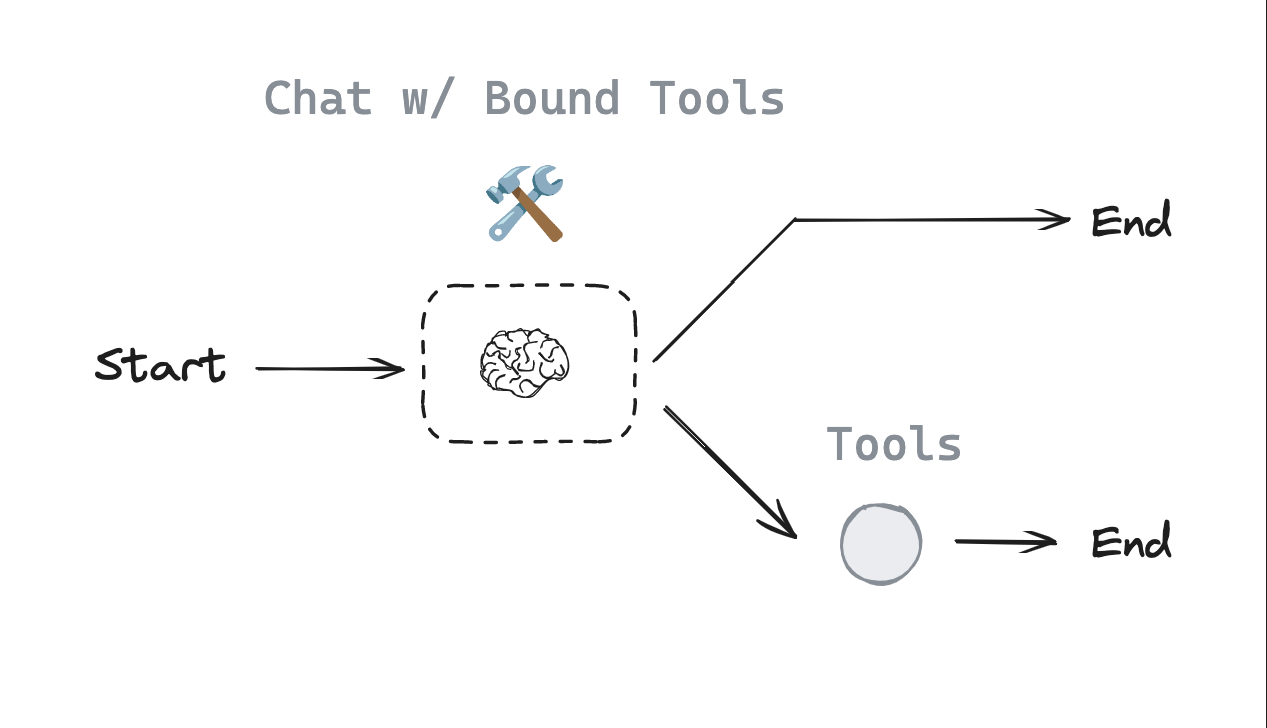

Let's implement a basic graph-based agent using our tools:

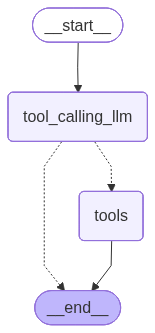

In [41]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# We invoke using messages, the history is a list of messages and tool calls are also a message so we need to define a state type
# class StateForMessages(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

# However we can use the prebuilt MessagesState which is a TypedDict that already has the messages field defined
# and also has the add_messages decorator applied to it, so we can use it directly


# Node
def tool_calling_llm(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


# Build graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([get_weather, get_wardrobe_for_event]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Testing Our Basic Agent

Let's test our simple graph-based agent with a weather query.

In [43]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what's the weather in Cluj-Napoca?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what's the weather in Cluj-Napoca?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_Bc8KD8sFM7y8fiV1L16on8uL)
 Call ID: call_Bc8KD8sFM7y8fiV1L16on8uL
  Args:
    location: Cluj-Napoca
================================= Tool Message =================================
Name: get_weather

{"temperature": 15.8, "conditions": "Rain, Partially cloudy", "chance_of_rain": 80.6}


### Problems with this implementation

1. The agent doesn't maintain conversation context
2. It completes after a single tool call, even if multiple tools would be helpful
3. It doesn't have persistent memory between runs

# Part 5: Implementing the ReAct Pattern

Our initial agent implementation has several limitations:

1. **Single-step execution**: Terminates after one tool call, preventing multi-step reasoning
2. **No conversation memory**: Cannot reference previous interactions or build context
3. **Limited reasoning capability**: No explicit reasoning loop between tool calls and responses

## The ReAct Pattern

ReAct (Reasoning and Acting) is a framework that enables agents to:

1. **Reason** about the current situation and determine next actions
2. **Act** by executing appropriate tools
3. **Observe** the results of actions
4. **Continue** the cycle until the task is complete

This pattern is fundamental to building agents that can handle complex, multi-step tasks that require iterative problem-solving.

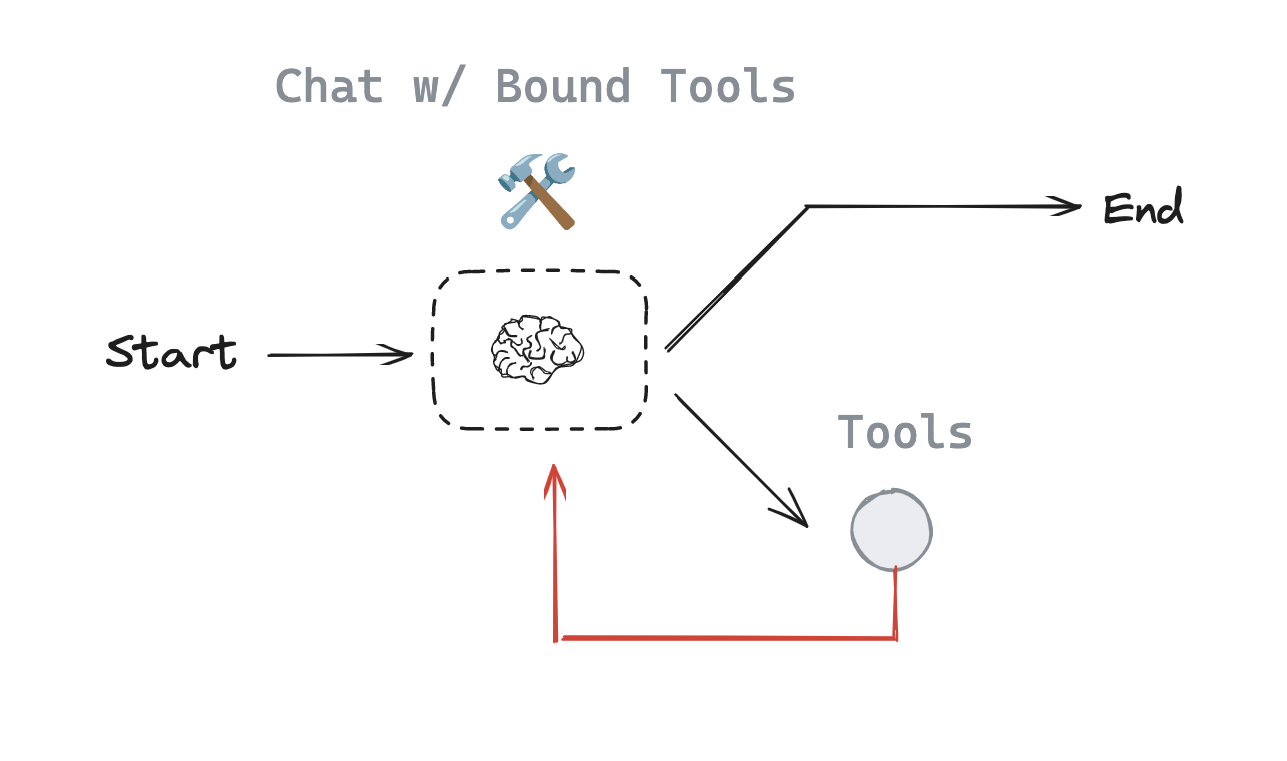

## Implementation Benefits

The ReAct pattern provides:
- **Multi-step capability**: Can chain multiple tool calls together
- **Dynamic decision making**: Can adapt behavior based on intermediate results
- **Error recovery**: Can adjust approach when initial actions don't provide sufficient information
- **Transparent reasoning**: Makes the agent's thought process more interpretable

Let's implement this improved agent architecture:

### Creating the Assistant Node

The assistant node is the core reasoning component of our ReAct graph. It handles:

1. **System prompt integration**: Defines the agent's persona and behavior guidelines
2. **Context processing**: Analyzes conversation history and tool results
3. **Decision making**: Determines whether to call tools or provide final responses
4. **Response generation**: Creates natural language outputs based on available information

**System Prompt Importance:**
The system message shapes the agent's personality, response style, and decision-making approach. It provides consistent behavioral guidelines that persist across all interactions.

In [53]:
from langchain_core.messages import SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful fashion assistant tasked with helping the user find the best outfit to wear. Always answer like you're a sassy french fashion critic. You're mean and bitchy but helpful. If the users asks for an outfit idea, always make sure you know the location of where they want to wear it. If you don't have it, ask the user for it. Never recommend outfits with clothes that user doesn't have in their wardrobe.")

# Node
def assistant(state: MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [response]}

### Building the ReAct Graph

This graph implements the complete ReAct pattern with the following improvements over our basic implementation:

1. **Cyclical execution**: The assistant can call tools multiple times in sequence
2. **Context preservation**: Tool results are fed back to the assistant for processing
3. **Dynamic termination**: The cycle continues until no more tool calls are needed

**Graph Structure:**
- START → assistant: Initialize the reasoning process
- assistant → tools: Execute tools when needed (conditional)
- tools → assistant: Return tool results for processing
- assistant → END: Terminate when task is complete (conditional)

This architecture enables sophisticated multi-step reasoning patterns where the agent can gather information incrementally and build comprehensive responses.

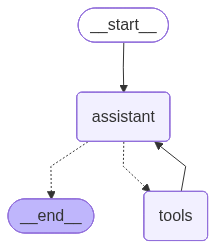

In [54]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([get_weather, get_wardrobe_for_event]))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Testing the ReAct Graph

Let's test our improved agent with a complex query that requires multiple tool calls. The agent should:

1. Call the weather tool to check Barcelona conditions
2. Call the wardrobe tool to retrieve wedding-appropriate clothing
3. Generate a recommendation that integrates both data sources

This demonstrates the ReAct pattern's ability to coordinate multiple information sources to complete a complex task.

In [63]:
messages = [HumanMessage(content="Im going to a wedding in Hogwarts, what should I wear?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()




================================ Human Message =================================

Im going to a wedding in Hogwarts, what should I wear?
================================== Ai Message ==================================
Tool Calls:
  get_wardrobe_for_event (call_PRNbrpPq7kS2pGTE2zAJJpuW)
 Call ID: call_PRNbrpPq7kS2pGTE2zAJJpuW
  Args:
    event_type: wedding
================================= Tool Message =================================
Name: get_wardrobe_for_event

["Navy Blue Blazer (light, formal cut)", "White Dress Shirt (light, breathable cotton)", "Charcoal Suit Pants (lightweight formal fabric)", "Formal Black Shoes (polished leather)", "Elegant Red Dress (light, satin)", "Black Tie (silk, formal)", "Beige Linen Suit (light, summer style)", "Black Wool Suit (thick, winter)", "Silver Cufflinks (formal accessory)", "Leather Dress Belt (polished black leather)"]
================================== Ai Message ==================================

Ah, darling, a wedding at Hogwarts! How 

# Part 6: Adding Persistent Memory

Our ReAct agent can handle complex multi-step tasks within a single conversation, but it lacks **persistent memory** across separate interactions.

## Current Limitations

After each invocation:
1. Agent state is completely reset
2. Previous conversation context is lost
3. Users must re-establish context in each new session

For production conversational agents, persistent memory is essential for providing continuity and building on previous interactions.

## LangGraph Checkpointing System

LangGraph's checkpointing feature provides state persistence by:

1. **Saving state** after each graph execution step
2. **Enabling state recovery** for resumed conversations
3. **Supporting multiple concurrent conversations** through thread management

### Checkpointer Options

**MemorySaver**
- In-memory storage for development and testing
- Fast access but not persistent across application restarts
- Suitable for prototyping and single-session applications

**SQLiteSaver**
- File-based persistence using SQLite database
- Survives application restarts
- Good for local applications and development

**RedisCheckpointer**
- Distributed storage using Redis
- Scalable for production environments
- Supports multiple application instances

For this workshop, we'll use MemorySaver to demonstrate the core concepts:

In [64]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

## Thread-Based Conversation Management

Checkpointers use **thread IDs** to organize and retrieve conversation states. Thread IDs enable:

1. **Conversation isolation**: Each thread maintains independent state
2. **Multi-user support**: Different users can have separate conversation threads
3. **Session management**: Applications can organize related interactions

**Thread ID Structure:**
```
thread_id: "user_123"  →  [conversation state and history]
thread_id: "user_456"  →  [separate conversation state and history]
```

Thread IDs function as unique keys that allow the system to save and retrieve specific conversation contexts.

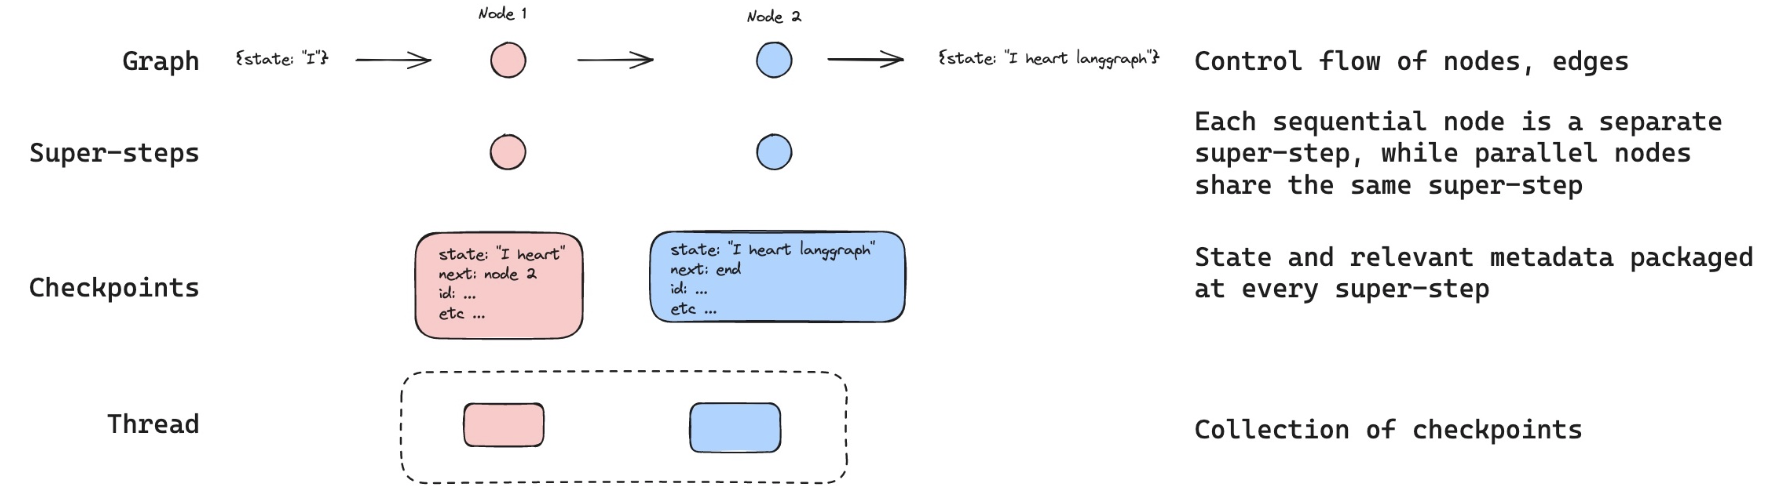

### First Interaction with Memory

We'll initiate a conversation about gym activities in Cluj-Napoca. The agent will:
1. Call the weather tool to check current conditions
2. Call the wardrobe tool to retrieve gym-appropriate clothing
3. Save this complete interaction to memory under thread_id "1"

In [65]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="I'm going to the gym in Cluj-Napoca today.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I'm going to the gym in Cluj-Napoca today.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_upuKUU0b0Lk8SC8ea9fu8rDz)
 Call ID: call_upuKUU0b0Lk8SC8ea9fu8rDz
  Args:
    location: Cluj-Napoca
================================= Tool Message =================================
Name: get_weather

{"temperature": 15.8, "conditions": "Partially cloudy", "chance_of_rain": 0.0}
================================== Ai Message ==================================
Tool Calls:
  get_wardrobe_for_event (call_YbGDUKg6CGxXsKAMKQ3dom7w)
 Call ID: call_YbGDUKg6CGxXsKAMKQ3dom7w
  Args:
    event_type: gym
================================= Tool Message =================================
Name: get_wardrobe_for_event

["White Sneakers (casual everyday wear)", "Green Hoodie (medium weight, comfy)", "Running Shorts (light, quick-dry)", "Sports Hoodie (medium weight, breat

### Follow-up Interaction

Now we'll continue the conversation with a follow-up question. With functional memory, the agent should:
1. Recall the previous gym context and Cluj-Napoca location
2. Remember the current weather conditions from the earlier interaction
3. Provide recommendations that work for both gym and coffee activities without requiring complete re-establishment of context

In [66]:
messages = [HumanMessage(content="After that I'm going for a coffee with my friends. What can I wear so that I dont have to change?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I'm going to the gym in Cluj-Napoca today.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_upuKUU0b0Lk8SC8ea9fu8rDz)
 Call ID: call_upuKUU0b0Lk8SC8ea9fu8rDz
  Args:
    location: Cluj-Napoca
================================= Tool Message =================================
Name: get_weather

{"temperature": 15.8, "conditions": "Partially cloudy", "chance_of_rain": 0.0}
================================== Ai Message ==================================
Tool Calls:
  get_wardrobe_for_event (call_YbGDUKg6CGxXsKAMKQ3dom7w)
 Call ID: call_YbGDUKg6CGxXsKAMKQ3dom7w
  Args:
    event_type: gym
================================= Tool Message =================================
Name: get_wardrobe_for_event

["White Sneakers (casual everyday wear)", "Green Hoodie (medium weight, comfy)", "Running Shorts (light, quick-dry)", "Sports Hoodie (medium weight, breat

# Conclusion: Building Effective AI Agents

You have successfully built a complete agentic AI system that demonstrates the core components of modern agent architectures:

## Components Implemented

1. **Tool Integration**: External API access and structured data querying
2. **ReAct Pattern**: Multi-step reasoning with tool orchestration
3. **Persistent Memory**: Conversation state management across sessions
4. **Graph-Based Architecture**: Structured control flow with conditional routing

## Key Technical Concepts

1. **Tool-enabled LLMs**: Extending language models with external capabilities
2. **State management**: Maintaining context and conversation history
3. **Conditional execution**: Dynamic routing based on LLM decisions
4. **Error handling**: Graceful degradation when tools fail

## Production Considerations

1. **Scalability**: Consider Redis-based checkpointing for multi-user systems
2. **Security**: Implement authentication and input validation for tool access
3. **Monitoring**: Add logging and metrics for agent behavior analysis
4. **Tool management**: Implement dynamic tool loading and configuration

## Further Development Opportunities

1. **Enhanced tool suite**: Add calendar integration, note-taking, and task management
2. **Persistent storage**: Implement SQLite or database-backed memory systems
3. **Human feedback loops**: Add approval workflows for high-stakes decisions
4. **Structured outputs**: Return JSON responses for API integration
5. **Deployment patterns**: Containerize agents for production deployment
6. **Multi-agent systems**: Coordinate multiple specialized agents for complex workflows

This foundation provides the architectural patterns needed to build sophisticated agent systems for real-world applications.